In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import pandas as pd
import copy

from sklearn.metrics import roc_curve , roc_auc_score , precision_recall_curve

pd.options.display.max_rows = 200

# Import Models and Test Data

In [20]:
rf = pickle.load(open('rf_final.p','rb'))
gb = pickle.load(open('gb_final.p','rb'))
logit= pickle.load(open('logRegModel.p','rb'))
vote_soft = pickle.load(open('voting_classifer_soft.p','rb'))

In [21]:
X_val = pickle.load(open('X_val_processed.p','rb'))
y_val = pickle.load(open('y_val.p','rb'))
X_test = pickle.load(open('X_test_processed.p','rb'))
y_test = pickle.load(open('y_test.p','rb'))


In [22]:
y_val.shape

(1069,)

# Build a ROC curve

In [23]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_val,rf.predict_proba(X_val)[:,1])
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_val,gb.predict_proba(X_val)[:,1])
logit_fpr, logit_tpr, logit_thresholds = roc_curve(y_val,logit.predict_proba(X_val)[:,1])
vote_soft_fpr, vote_soft_tpr, vote_soft_thresholds = roc_curve(y_val,vote_soft.predict_proba(X_val)[:,1])



roc_auc_rf = roc_auc_score(y_val,rf.predict_proba(X_val)[:,1])
roc_auc_gb = roc_auc_score(y_val,gb.predict_proba(X_val)[:,1])
roc_auc_logistic = roc_auc_score(y_val,logit.predict_proba(X_val)[:,1])
roc_auc_vote_soft = roc_auc_score(y_val,vote_soft.predict_proba(X_val)[:,1])



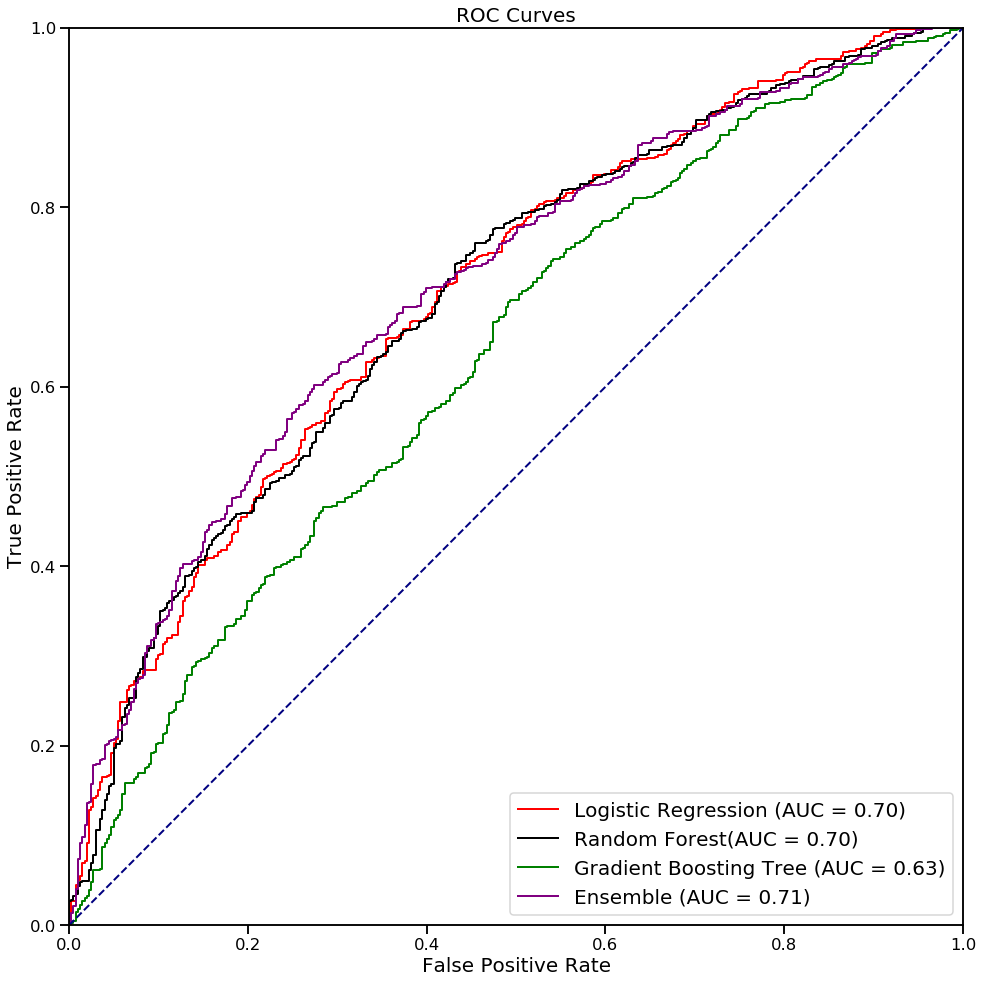

In [24]:
sns.set_context("talk")
fig = plt.figure(figsize=(14,14))
lw = 2


plt.plot(logit_fpr, logit_tpr, color='red',
         lw=lw, label='Logistic Regression (AUC = %0.2f)' % roc_auc_logistic)
plt.plot(rf_fpr, rf_tpr, color='black',
         lw=lw, label='Random Forest(AUC = %0.2f)' % roc_auc_rf)
plt.plot(gb_fpr, gb_tpr, color='green',
         lw=lw, label='Gradient Boosting Tree (AUC = %0.2f)' % roc_auc_gb)
plt.plot(vote_soft_fpr,vote_soft_tpr, color='purple',
         lw=lw, label='Ensemble (AUC = %0.2f)' % roc_auc_vote_soft)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate',fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('ROC Curves', fontsize = 20)
plt.legend(loc="lower right", fontsize = 20)
plt.tight_layout()
# plt.savefig('roc_curves_all_ALL.png')
# plt.savefig('roc_curves_svg_all_all.svg')
plt.show()

# Build a PR curve

In [25]:
rf_percision, rf_recall, rf_thresholds = precision_recall_curve(y_val,rf.predict_proba(X_val)[:,1])
gb_percision, gb_recall, gb_thresholds = precision_recall_curve(y_val,gb.predict_proba(X_val)[:,1])
logit_percision, logit_recall, logit_thresholds = precision_recall_curve(y_val,logit.predict_proba(X_val)[:,1])
vote_soft_percision, vote_soft_recall, vote_soft_thresholds = precision_recall_curve(y_val,vote_soft.predict_proba(X_val)[:,1])




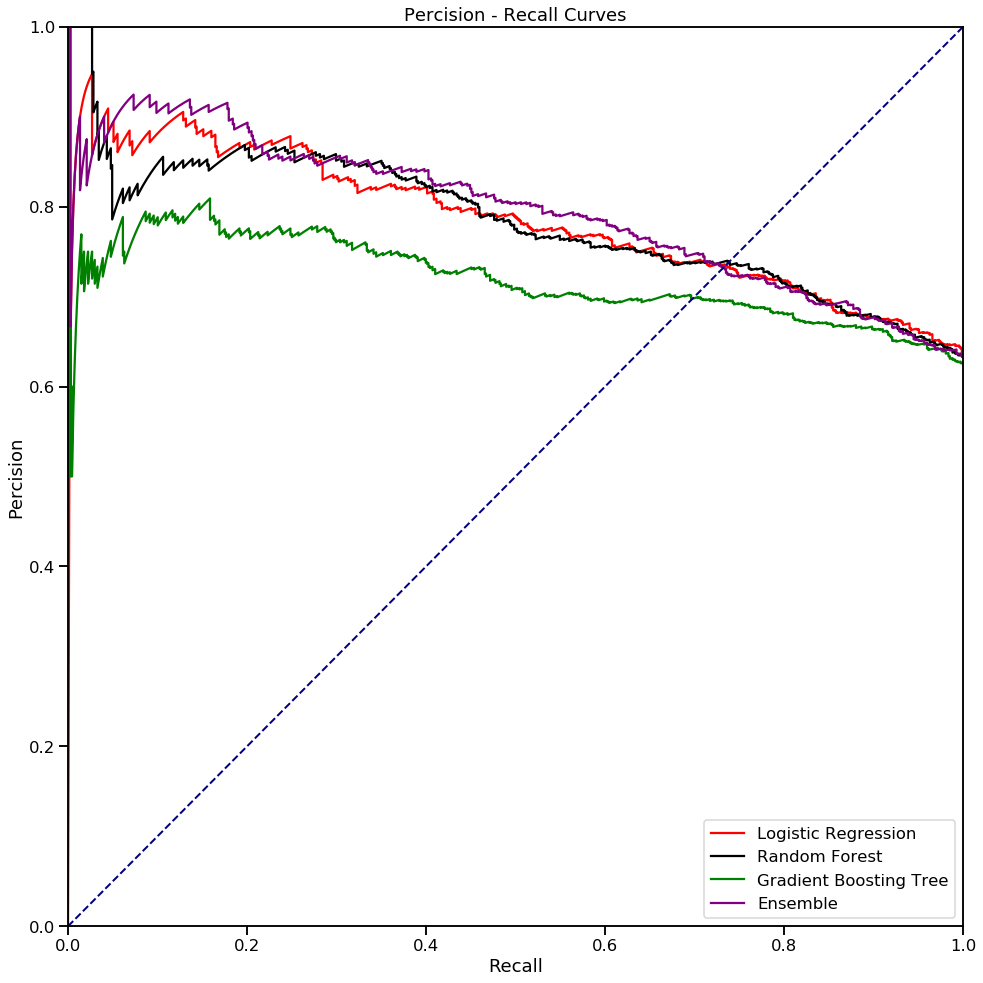

In [26]:
sns.set_context('talk')
fig = plt.figure(figsize=(14,14))



plt.plot( logit_recall,logit_percision, color='red',
          label='Logistic Regression')
plt.plot( rf_recall,rf_percision, color='black',
          label='Random Forest')
plt.plot( gb_recall,gb_percision, color='green',
          label='Gradient Boosting Tree')
plt.plot( vote_soft_recall,vote_soft_percision, color='purple',
          label='Ensemble')



plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Percision')
plt.title('Percision - Recall Curves')
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig('roc_curves_all_ALL.png')
# plt.savefig('roc_curves_svg_all_all.svg')
plt.show()

# Threshold Tuning 

In [27]:
threshold_tuner = pd.DataFrame({
    'y_val':y_val,
    'rf_prob':rf.predict_proba(X_val)[:,1],
    'gb_prob':gb.predict_proba(X_val)[:,1],
    'logit_prob':logit.predict_proba(X_val)[:,1],
    'ensemble_prob':vote_soft.predict_proba(X_val)[:,1]
})

In [28]:
threshold_tuner['threshold'] = 0 
threshold_tuner_exploded = pd.DataFrame(columns = threshold_tuner.columns)


for n in range(101):
    threshold_tuner['threshold'] = n/100
    threshold_tuner_exploded=threshold_tuner_exploded.append(threshold_tuner,ignore_index=True)

In [29]:

threshold_tuner_exploded['rf_fp'] = 0
threshold_tuner_exploded['rf_fn'] = 0



threshold_tuner_exploded['gb_fp'] = 0
threshold_tuner_exploded['gb_fn'] = 0



threshold_tuner_exploded['logit_fp'] = 0
threshold_tuner_exploded['logit_fn'] = 0



threshold_tuner_exploded['ensemble_fp'] = 0
threshold_tuner_exploded['ensemble_fn'] = 0


In [30]:
threshold_tuner_exploded.sample(20)

,y_val,rf_prob,gb_prob,logit_prob,ensemble_prob,threshold,rf_fp,rf_fn,gb_fp,gb_fn,logit_fp,logit_fn,ensemble_fp,ensemble_fn
86225,0,0.430631,0.000105,0.086943,0.167986,0.80,0,0,0,0,0,0,0,0
101705,1,0.565943,0.790037,0.456695,0.381324,0.95,0,0,0,0,0,0,0,0
80344,1,0.583026,0.982951,0.654937,0.453873,0.75,0,0,0,0,0,0,0,0
86438,1,0.679589,0.985959,0.745558,0.805072,0.80,0,0,0,0,0,0,0,0
27358,0,0.649137,0.613746,0.784695,0.491951,0.25,0,0,0,0,0,0,0,0
38843,0,0.569358,0.052346,0.513757,0.377047,0.36,0,0,0,0,0,0,0,0
49516,1,0.681006,0.984163,0.855708,0.842306,0.46,0,0,0,0,0,0,0,0
81425,1,0.686152,0.980120,0.769274,0.813688,0.76,0,0,0,0,0,0,0,0
60446,1,0.576580,0.880799,0.601192,0.727016,0.56,0,0,0,0,0,0,0,0
86271,1,0.662730,0.649699,0.611764,0.697344,0.80,0,0,0,0,0,0,0,0


In [31]:
tte=copy.deepcopy(threshold_tuner_exploded)

In [32]:
tte.loc[(tte.rf_prob>tte.threshold) & tte.y_val==0, 'rf_fp'] = int(1)
tte.loc[(tte.gb_prob>tte.threshold) & tte.y_val==0, 'gb_fp'] = int(1)
tte.loc[(tte.logit_prob>tte.threshold) & tte.y_val==0, 'logit_fp'] = int(1)
tte.loc[(tte.ensemble_prob>tte.threshold) & tte.y_val==0, 'ensemble_fp'] = int(1)

tte.loc[(tte.rf_prob<tte.threshold) & tte.y_val==1, 'rf_fn'] = int(1)
tte.loc[(tte.gb_prob<tte.threshold) & tte.y_val==1, 'gb_fn'] = int(1)
tte.loc[(tte.logit_prob<tte.threshold) & tte.y_val==1, 'logit_fn'] = int(1)
tte.loc[(tte.ensemble_prob<tte.threshold) & tte.y_val==1, 'ensemble_fn'] = int(1)

In [33]:
tte.head()

,y_val,rf_prob,gb_prob,logit_prob,ensemble_prob,threshold,rf_fp,rf_fn,gb_fp,gb_fn,logit_fp,logit_fn,ensemble_fp,ensemble_fn
0,0,0.654232,0.996876,0.741954,0.791918,0.0,1,0,1,0,1,0,1,0
1,1,0.705112,0.980090,0.805122,0.585249,0.0,0,0,0,0,0,0,0,0
2,1,0.618335,0.996336,0.681903,0.682210,0.0,0,0,0,0,0,0,0,0
3,0,0.496709,0.011612,0.104190,0.194834,0.0,1,0,1,0,1,0,1,0
4,1,0.684378,0.908413,0.654902,0.769241,0.0,0,0,0,0,0,0,0,0


In [34]:
tte['rf_cost'] = tte['rf_fp'] * 150000/2 + tte['rf_fn']*8000
tte['gb_cost'] = tte['gb_fp'] * 150000/2 + tte['gb_fn']*8000
tte['ensemble_cost'] = tte['ensemble_fp'] * 150000/2 + tte['ensemble_fn']*8000
tte['logit_cost'] = tte['logit_fp'] * 150000/2 + tte['logit_fn']*8000

In [37]:
tte.groupby(by= 'threshold').sum().sort_values(by= 'ensemble_cost', ascending = True)

,rf_prob,gb_prob,logit_prob,ensemble_prob,rf_fp,rf_fn,gb_fp,gb_fn,logit_fp,logit_fn,ensemble_fp,ensemble_fn,rf_cost,gb_cost,ensemble_cost,logit_cost
threshold,,,,,,,,,,,,,,,,
0.00,664.408852,733.274654,668.769389,684.881289,401,0,401,0,401,0,401,0,30075000.0,30075000.0,30075000.0,30075000.0
0.20,664.408852,733.274654,668.769389,684.881289,401,0,507,106,402,1,401,0,30075000.0,38873000.0,30075000.0,30158000.0
0.19,664.408852,733.274654,668.769389,684.881289,401,0,505,104,402,1,401,0,30075000.0,38707000.0,30075000.0,30158000.0
0.18,664.408852,733.274654,668.769389,684.881289,401,0,503,102,402,1,401,0,30075000.0,38541000.0,30075000.0,30158000.0
0.17,664.408852,733.274654,668.769389,684.881289,401,0,500,99,402,1,401,0,30075000.0,38292000.0,30075000.0,30158000.0
0.16,664.408852,733.274654,668.769389,684.881289,401,0,499,98,401,0,401,0,30075000.0,38209000.0,30075000.0,30075000.0
0.15,664.408852,733.274654,668.769389,684.881289,401,0,499,98,401,0,401,0,30075000.0,38209000.0,30075000.0,30075000.0
0.14,664.408852,733.274654,668.769389,684.881289,401,0,497,96,401,0,401,0,30075000.0,38043000.0,30075000.0,30075000.0
0.13,664.408852,733.274654,668.769389,684.881289,401,0,493,92,401,0,401,0,30075000.0,37711000.0,30075000.0,30075000.0


In [36]:
tte.groupby(by= 'threshold').sum()

,rf_prob,gb_prob,logit_prob,ensemble_prob,rf_fp,rf_fn,gb_fp,gb_fn,logit_fp,logit_fn,ensemble_fp,ensemble_fn,rf_cost,gb_cost,ensemble_cost,logit_cost
threshold,,,,,,,,,,,,,,,,
0.00,664.408852,733.274654,668.769389,684.881289,401,0,401,0,401,0,401,0,30075000.0,30075000.0,30075000.0,30075000.0
0.01,664.408852,733.274654,668.769389,684.881289,401,0,433,32,401,0,401,0,30075000.0,32731000.0,30075000.0,30075000.0
0.02,664.408852,733.274654,668.769389,684.881289,401,0,444,43,401,0,401,0,30075000.0,33644000.0,30075000.0,30075000.0
0.03,664.408852,733.274654,668.769389,684.881289,401,0,454,53,401,0,401,0,30075000.0,34474000.0,30075000.0,30075000.0
0.04,664.408852,733.274654,668.769389,684.881289,401,0,457,56,401,0,401,0,30075000.0,34723000.0,30075000.0,30075000.0
0.05,664.408852,733.274654,668.769389,684.881289,401,0,463,62,401,0,401,0,30075000.0,35221000.0,30075000.0,30075000.0
0.06,664.408852,733.274654,668.769389,684.881289,401,0,468,67,401,0,401,0,30075000.0,35636000.0,30075000.0,30075000.0
0.07,664.408852,733.274654,668.769389,684.881289,401,0,475,74,401,0,401,0,30075000.0,36217000.0,30075000.0,30075000.0
0.08,664.408852,733.274654,668.769389,684.881289,401,0,480,79,401,0,401,0,30075000.0,36632000.0,30075000.0,30075000.0
